### Optimize params with other scipy methods

In [51]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import Functions
%run Functions.py
cwd = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/'
StationDataPath = cwd + 'data/HH_Data_small/'
year = 2017 
years = [2017, 2018, 2019, 2020]

### 1. All seasons 

In [7]:
# least_squares(fun, x0,  method='lm')
# fun = function, x0 = morris, bounds=(- inf, inf) (non obligatory), ‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK.
morris_params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', header = None)
col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
morris_params.columns = col_list
morris_params.index = morris_params.Station
morris_params

,lambdaGPP,radZero,alpha,beta,Tmin,Tmax,Topt,Station,iveg
Station,,,,,,,,,
FI-Hyy,0.35,220.0,0.2,0.4,1.0,40.2,19.8,FI-Hyy,0
FI-Let,0.40,130.0,0.1,0.8,0.6,39.0,21.0,FI-Let,0
SE-Lnn,0.45,250.0,0.1,0.2,1.0,39.0,21.0,SE-Lnn,5
SE-Ros,0.35,220.0,0.2,0.2,1.0,39.0,19.4,SE-Ros,0
SE-Deg,0.20,100.0,0.1,0.0,0.6,40.2,21.0,SE-Deg,6
SE-Htm,0.45,250.0,0.1,0.8,-0.6,40.6,19.0,SE-Htm,0
SE-Nor,0.30,250.0,0.2,1.0,1.0,39.8,20.6,SE-Nor,0


#### 1.1 For one station

In [8]:
snames = ['FI-Hyy']
stations, snames = get_stations_year(year)
for sitename in snames:
    df = get_station_observation_year(StationDataPath, sitename, year)


In [20]:
a = morris_params.loc[sitename]['alpha']
a = pd.to_numeric(a)
b = morris_params.loc[sitename]['beta']
b = pd.to_numeric(b)
t = pd.to_numeric(df['TA_F'], errors='coerce')

In [16]:
# define the bounds on the search
temp = df['TA_F'].tolist()
resp = df['RECO_DT_VUT_REF'].tolist()
x0 = np.array([a,b])
# perform the differential evolution search
result = least_squares(func_reco, x0,args = (temp,resp,))
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = func_reco(solution, temp, resp)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : The maximum number of function evaluations is exceeded.
Total Evaluations: 200
Solution: f([0.24134903 1.5213031 ]) = 220.83691


In [37]:
pred_morr = reco(a,b,t)

In [46]:
pred_ls = reco(solution[0], solution[1],t) 

Index(['RECO_morr', 'RECO_ls', 'date', 'RECO_DT_VUT_REF'], dtype='object')


<AxesSubplot:xlabel='date'>

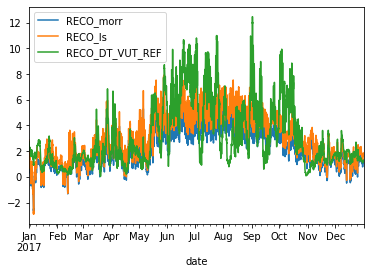

In [45]:
df_c = pd.concat([pred_morr.rename('RECO_morr'), pred_ls.rename('RECO_ls'), df[['date','RECO_DT_VUT_REF']]], axis = 1)
print(df_c.columns)
df_c.plot(x = 'date')

In [48]:
rmse = m_rmse(df_c['RECO_DT_VUT_REF'], pred_ls)#df_c['RECO_Pred'])
rmse

1.668417028406375

In [49]:
rmse = m_rmse(df_c['RECO_DT_VUT_REF'], pred_morr)#df_c['RECO_Pred'])
rmse

1.8845401647526614

#### 1.2 For all stations for all years 

In [53]:
for year in years: 
    stations, snames = get_stations_year(year)
    df_params_new = pd.DataFrame(index = snames, columns = ['new_RMSE_ls', 'alpha_ls', 'beta_ls'])
    
    morris_params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', header = None)
    col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
    morris_params.columns = col_list
    morris_params.index = morris_params.Station
    morris_params

    for sitename in snames:
        df = get_station_observation_year(StationDataPath, sitename, year)
        a = morris_params.loc[sitename]['alpha']
        a = pd.to_numeric(a)
        b = morris_params.loc[sitename]['beta']
        b = pd.to_numeric(b)
        t = pd.to_numeric(df['TA_F'], errors='coerce')

        temp = df['TA_F'].tolist()
        resp = df['RECO_DT_VUT_REF'].tolist()
        x0 = np.array([a,b])
        result = least_squares(func_reco, x0,args = (temp,resp,))
        
        pred_ls = reco(result['x'][0], result['x'][1],t) 
        rmse = m_rmse(df['RECO_DT_VUT_REF'], pred_ls)

        df_params_new.loc[sitename]['alpha_ls'] = result['x'][0]
        df_params_new.loc[sitename]['beta_ls'] = result['x'][1]
        df_params_new.loc[sitename]['new_RMSE_ls'] = rmse
        
    df_params_new.to_csv('Oslo_analysis/VPRMoutput/best_fit_ls_alpha_beta'+str(year)+'.csv')


In [56]:
for year in years: 
    stations, snames = get_stations_year(year)
# df (csv with year) with stationname, updated alpha beta rmse old rmse new for all stations 
    df_params_gpp = pd.DataFrame(index = snames, columns = ['new_RMSE_ls', 'lambdaGPP_ls', 'radZero_ls'])
    station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
    
    morris_params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', header = None)
    col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
    morris_params.columns = col_list
    morris_params.index = morris_params.Station
    morris_params

    for sitename in snames:
        print(sitename) 
        #get morris optimized parameters, meterological data and sentinel data 
        lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GPP_or = load_data_gpp(morris_params, station_data, sitename, year, StationDataPath)

        print('lamda: ', lambdaGPP, 'tscale: ', Tscale.shape, 'wscale: ', Wscale.shape, 'pscale: ', Pscale.shape, 'evi: ', EVI.shape, 'rad: ', Rad.shape, 'radZ: ', radZero,'original: ', GPP_or.shape)

        # optimize params with diff evolution
        
        a = morris_params.loc[sitename]['lambdaGPP']
        a = pd.to_numeric(a)
        b = morris_params.loc[sitename]['radZero']
        b = pd.to_numeric(b)
        
        x0 = np.array([a,b])
        result = least_squares(func_gee, x0, args = (Tscale, Wscale, Pscale, EVI, Rad, GPP_or,))
        
        pred_ls = GEE_calculate(result['x'][0], Tscale, Wscale, Pscale, EVI, Rad, result['x'][1])
        rmse = m_rmse(GPP_or, pred_ls) 

        # df_params_gpp.loc[sitename]['Station'] = sitename

        df_params_gpp.loc[sitename]['new_RMSE_ls'] = rmse
        df_params_gpp.loc[sitename]['lambdaGPP_ls'] = result['x'][0]
        df_params_gpp.loc[sitename]['radZero_ls'] = result['x'][1]
        
    df_params_new.to_csv('Oslo_analysis/VPRMoutput/best_fit_ls_lambdaGPP_radZero'+str(year)+'.csv')


FI-Hyy
lamda:  0.35 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  220.0 original:  (17520,)
FI-Let
lamda:  0.4 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  130.0 original:  (17520,)
SE-Lnn
lamda:  0.45 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  250.0 original:  (17520,)
SE-Ros
lamda:  0.35 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  220.0 original:  (17520,)
SE-Deg
lamda:  0.2 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  100.0 original:  (17520,)
SE-Htm
lamda:  0.45 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  250.0 original:  (17520,)
SE-Nor
lamda:  0.3 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  250.0 original:  (17520,)
FI-Hyy
lamda:  0.35 tscale:  (17520,) wscale

### 2. No winter

In [54]:
for year in years: 
    stations, snames = get_stations_year(year)
    df_params_new = pd.DataFrame(index = snames, columns = ['new_RMSE_ls', 'alpha_ls', 'beta_ls'])
    
    morris_params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_nowinter_'+str(year)+'.csv', header = None)
    col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
    morris_params.columns = col_list
    morris_params.index = morris_params.Station
    morris_params

    for sitename in snames:
        df = get_station_observation_year(StationDataPath, sitename, year)
        df.date = pd.to_datetime(df.date)
        df['month'] = df['date'].dt.month
        df = df[df['month'] != 12]
        df = df[df['month'] != 2]
        df = df[df['month'] != 1]
           
        a = morris_params.loc[sitename]['alpha']
        a = pd.to_numeric(a)
        b = morris_params.loc[sitename]['beta']
        b = pd.to_numeric(b)
        t = pd.to_numeric(df['TA_F'], errors='coerce')

        temp = df['TA_F'].tolist()
        resp = df['RECO_DT_VUT_REF'].tolist()
        x0 = np.array([a,b])
        result = least_squares(func_reco, x0,args = (temp,resp,))
        
        pred_ls = reco(result['x'][0], result['x'][1],t) 
        rmse = m_rmse(df['RECO_DT_VUT_REF'], pred_ls)

        df_params_new.loc[sitename]['alpha_ls'] = result['x'][0]
        df_params_new.loc[sitename]['beta_ls'] = result['x'][1]
        df_params_new.loc[sitename]['new_RMSE_ls'] = rmse
        
    df_params_new.to_csv('Oslo_analysis/VPRMoutput/best_fit_ls_alpha_beta_nowinter_'+str(year)+'.csv')

In [61]:
for year in years: 
    stations, snames = get_stations_year(year)
# df (csv with year) with stationname, updated alpha beta rmse old rmse new for all stations 
    df_params_gpp = pd.DataFrame(index = snames, columns = ['new_RMSE_ls', 'lambdaGPP_ls', 'radZero_ls'])
    station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
    station_data.loc[:,'month'] = pd.to_datetime(station_data.index).month.to_list()
    station_data = station_data[station_data['month']!= 12]
    station_data = station_data[station_data['month']!= 1]
    station_data = station_data[station_data['month']!= 2]
    
    morris_params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_nowinter_'+str(year)+'.csv', header = None)
    col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
    morris_params.columns = col_list
    morris_params.index = morris_params.Station
    morris_params

    for sitename in snames:
        print(sitename) 
        #get morris optimized parameters, meterological data and sentinel data 
        lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GPP_or = load_data_gpp(morris_params, station_data, sitename, year, StationDataPath, months = True)
        
        print('lamda: ', lambdaGPP, 'tscale: ', Tscale.shape, 'wscale: ', Wscale.shape, 'pscale: ', Pscale.shape, 'evi: ', EVI.shape, 'rad: ', Rad.shape, 'radZ: ', radZero,'original: ', GPP_or.shape)

        # optimize params with diff evolution
        
        a = morris_params.loc[sitename]['lambdaGPP']
        a = pd.to_numeric(a)
        b = morris_params.loc[sitename]['radZero']
        b = pd.to_numeric(b)
        
        x0 = np.array([a,b])
        result = least_squares(func_gee, x0, args = (Tscale, Wscale, Pscale, EVI, Rad, GPP_or,))
        
        pred_ls = GEE_calculate(result['x'][0], Tscale, Wscale, Pscale, EVI, Rad, result['x'][1])
        rmse = m_rmse(GPP_or, pred_ls) 

        # df_params_gpp.loc[sitename]['Station'] = sitename

        df_params_gpp.loc[sitename]['new_RMSE_ls'] = rmse
        df_params_gpp.loc[sitename]['lambdaGPP_ls'] = result['x'][0]
        df_params_gpp.loc[sitename]['radZero_ls'] = result['x'][1]
        
    df_params_new.to_csv('Oslo_analysis/VPRMoutput/best_fit_ls_lambdaGPP_radZero_nowinter'+str(year)+'.csv')


FI-Hyy
lamda:  0.4 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  190.0 original:  (13200,)
FI-Let
lamda:  0.4 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  130.0 original:  (13200,)
SE-Lnn
lamda:  0.45 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  250.0 original:  (13200,)
SE-Ros
lamda:  0.35 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  220.0 original:  (13200,)
SE-Deg
lamda:  0.2 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  100.0 original:  (13200,)
SE-Htm
lamda:  0.45 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  250.0 original:  (13200,)
SE-Nor
lamda:  0.25 tscale:  (13200,) wscale:  (13200,) pscale:  (13200,) evi:  (13200,) rad:  (13200,) radZ:  250.0 original:  (13200,)
FI-Hyy
lamda:  0.3 tscale:  (13200,) wscale: